In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns
import os

In [90]:
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [4]:
D = 30
N = 10000
z_size = 8

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

global_t = 0.0096
k_lab = [D//10, D//6, D//3, D//2, D]
trial_num = 5

In [5]:
train_data, test_data = generate_synthetic_data_with_noise(N, z_size, D)
train_data.to(device)
test_data.to(device)

tensor([[0.0000, 0.1907, 0.0000,  ..., 0.5329, 0.6371, 0.4690],
        [0.0000, 0.0000, 0.0000,  ..., 0.3878, 0.3787, 0.6062],
        [0.1067, 0.0000, 0.0000,  ..., 0.4175, 0.3398, 0.6803],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4536, 0.8283, 0.6763],
        [0.0000, 0.2083, 0.0000,  ..., 0.6805, 0.5686, 0.5650],
        [0.0000, 0.0000, 0.0000,  ..., 0.1979, 0.5258, 0.3618]],
       device='cuda:0')

In [6]:
BASE_PATH = "../data/models/final_run/"
# BASE_PATH = '/scratch/ns3429/sparse-subset/data/models/final_run/'

In [7]:
def load_trial_model(trial_path, k):
    if ('vanilla_vae_gumbel' in trial_path):
        model = VAE_Gumbel(2*D, 100, 20, k = k, t = global_t) 
    if ('batching_gumbel_vae' in trial_path):
        model = VAE_Gumbel_NInsta(2*D, 100, 20, k = k, t = global_t)
    if ('globalgate_vae' in trial_path):
        model = VAE_Gumbel_GlobalGate(2*D, 100, 20, k = k, t = global_t)
    if ('runningstate_vae' in trial_path):
        model = VAE_Gumbel_RunningState(2*D, 100, 20, k = k, t = global_t, alpha = 0.9)
    if ('concrete_vae_nmsl' in trial_path):
        model = ConcreteVAE_NMSL(2*D, 100, 20, k = k, t = global_t)
    
    model.load_state_dict(torch.load(trial_path))
    model.to(device)
    model.eval()
    
    return model

In [8]:
def obtain_model_metrics(model):
    pass

In [9]:
# test model
path = '../data/models/final_run/vanilla_vae_gumbel/k_15/model_trial_3.pt'
model = VAE_Gumbel(2*D, 100, 20, k = 15, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)

VAE_Gumbel(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=100, out_features=20, bias=True)
  (enc_logvar): Linear(in_features=100, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=60, bias=True)
    (3): Sigmoid()
  )
  (weight_creator): Sequential(
    (0): Linear(in_features=60, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=60, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)

BCE

In [10]:
test_df = test_data[0:64, :]
with torch.no_grad():
    pred_df = model(test_df)[0]

In [11]:
test_df.mean(dim = 0)

tensor([0.0464, 0.1195, 0.0845, 0.0104, 0.2252, 0.1259, 0.1879, 0.2976, 0.1553,
        0.1303, 0.3214, 0.1200, 0.0780, 0.2892, 0.1563, 0.0764, 0.1087, 0.0170,
        0.3132, 0.1194, 0.0414, 0.1190, 0.1890, 0.1809, 0.1659, 0.1510, 0.1903,
        0.1344, 0.0871, 0.0294, 0.4809, 0.4847, 0.4540, 0.4661, 0.4507, 0.5386,
        0.5251, 0.4553, 0.4645, 0.5043, 0.5350, 0.4467, 0.4940, 0.4733, 0.5062,
        0.4916, 0.4410, 0.4825, 0.4733, 0.4785, 0.5255, 0.4801, 0.5315, 0.5335,
        0.5443, 0.4986, 0.5396, 0.4663, 0.4663, 0.4903], device='cuda:0')

In [12]:
pred_df.mean(dim=0)

tensor([0.0598, 0.1216, 0.0932, 0.0215, 0.2048, 0.1185, 0.1885, 0.3035, 0.1670,
        0.1427, 0.3140, 0.1237, 0.0896, 0.2727, 0.1712, 0.0839, 0.1040, 0.0147,
        0.3175, 0.1058, 0.0482, 0.1075, 0.1960, 0.1726, 0.1569, 0.1397, 0.1909,
        0.1396, 0.0900, 0.0293, 0.4693, 0.5045, 0.4498, 0.4650, 0.4320, 0.5508,
        0.5151, 0.4588, 0.4848, 0.5052, 0.5325, 0.4693, 0.5141, 0.4665, 0.5050,
        0.5037, 0.4518, 0.5022, 0.4757, 0.4791, 0.5430, 0.4874, 0.5153, 0.5137,
        0.5315, 0.5028, 0.5218, 0.4825, 0.4930, 0.5091], device='cuda:0')

In [13]:
F.binary_cross_entropy(pred_df, test_df, reduction = 'sum')

tensor(1867.2538, device='cuda:0')

In [14]:
def bce_model(data, model):
    test_loss = 0
    inds = np.arange(test_data.shape[0])
    with torch.no_grad():
        for i in range(math.ceil(len(data)/batch_size)):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = data[batch_ind, :]

            test_pred = model(batch_data)[0]


            test_loss += F.binary_cross_entropy(test_pred, batch_data, reduction='sum')

            del batch_data
    return test_loss / data.shape[0]

In [15]:
bce_model(test_data, model)

tensor(29.2327, device='cuda:0')

In [16]:
def top_logits_gumbel_vanilla_vae_gumbel(data, model):
    assert isinstance(model, VAE_Gumbel)
    all_logits = torch.zeros(data.shape[1], dtype = torch.float32)
    all_subsets = torch.zeros(data.shape[1], dtype = torch.float32)
    all_logits = all_logits.to(device)
    all_subsets = all_subsets.to(device)
    inds = np.arange(data.shape[0])
    with torch.no_grad():
        for i in range(math.ceil(len(data)/batch_size)):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = data[batch_ind, :]
            
            logits = model.weight_creator(batch_data)
            
            
            topk_logits = torch.topk(logits, k = model.k, dim = 1, sorted = True)[1]
            one_hotted_top_k = torch.nn.functional.one_hot(topk_logits, num_classes = data.shape[1]).sum(dim = 1)
            
            #subsets = sample_subset(logits, model.k, model.t, separate = True)
            subsets = sample_subset(logits, model.k, model.t)
            #max_idx = torch.argmax(subsets, 2, keepdim=True)
            #one_hot = Tensor(subsets.shape)
            #one_hot.zero_()
            #one_hot.scatter_(2, max_idx, 1)
    
    
            all_logits += one_hotted_top_k.sum(dim = 0)
            #all_subsets += one_hot.sum(dim = (0, 1))
            all_subsets += subsets.sum(dim = 0)
            
            
    
        all_logits /= train_data.shape[0]
        all_subsets /= train_data.shape[0]
    
    return all_logits, all_subsets

In [17]:
def top_logits_gumbel_batching_vae_gumbel(data, model):
    assert isinstance(model, VAE_Gumbel_NInsta)
    all_logits = torch.zeros(data.shape[1], dtype = torch.float32)
    all_subsets = torch.zeros(data.shape[1], dtype = torch.float32)
    all_logits = all_logits.to(device)
    all_subsets = all_subsets.to(device)
    inds = np.arange(data.shape[0])
    num_batches = math.ceil(len(data)/batch_size)
    with torch.no_grad():
        for i in range(num_batches):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = data[batch_ind, :]

            w0 = model.weight_creator(batch_data)
            w = w0.mean(dim = 0)
            top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
            enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = 2*D).sum(dim = 0)

            #subsets = sample_subset(w, model.k,model.t,True)
            subsets = sample_subset(w, model.k,model.t)
            #max_idx = torch.argmax(subsets, 1, keepdim=True)
            #one_hot = Tensor(subsets.shape)
            #one_hot.zero_()
            #one_hot.scatter_(1, max_idx, 1)
            
            all_logits += enc_top_logits
            all_subsets += subsets
    
        all_logits /= num_batches
        all_subsets /= num_batches
    
    return all_logits, all_subsets

In [18]:
def top_logits_gumbel_globalgate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_GlobalGate)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = 2*D).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

In [19]:
def top_logits_gumbel_runningstate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_RunningState)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = 2*D).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

In [20]:
def top_logits_gumbel_concrete_vae_nsml(data, model):
    assert isinstance(model, ConcreteVAE_NMSL)
    
    with torch.no_grad():
        max_idx = torch.argmax(model.logit_enc, 1, keepdim=True)
        one_hot = Tensor(model.logit_enc.shape)
        one_hot.zero_()
        one_hot.scatter_(1, max_idx, 1)

        all_logits = one_hot.sum(dim = 0)

        w = gumbel_keys(model.logit_enc, EPSILON = torch.finfo(torch.float32).eps)
        w = torch.softmax(w/model.t, dim = -1)
        subset_indices = w.clone().detach()

        #max_idx = torch.argmax(subset_indices, 1, keepdim=True)
        #one_hot = Tensor(subset_indices.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        all_subsets = subset_indices.sum(dim = 0)
        
    return all_logits, all_subsets

In [28]:
# test model
path = '../data/models/final_run/vanilla_vae_gumbel/k_30/model_trial_3.pt'
model = VAE_Gumbel(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
top_logits_gumbel_vanilla_vae_gumbel(test_data, model)

(tensor([0.1679, 0.0725, 0.2500, 0.0999, 0.1931, 0.1960, 0.1079, 0.0981, 0.1766,
         0.2060, 0.2311, 0.1616, 0.2488, 0.1511, 0.2401, 0.2033, 0.1896, 0.1036,
         0.1706, 0.2486, 0.2453, 0.2444, 0.2500, 0.2394, 0.0765, 0.2484, 0.1963,
         0.2431, 0.2380, 0.1553, 0.2095, 0.0413, 0.0190, 0.1693, 0.0561, 0.0000,
         0.0158, 0.1100, 0.0000, 0.0518, 0.0086, 0.0050, 0.0000, 0.1583, 0.0405,
         0.0806, 0.2013, 0.0150, 0.0000, 0.0000, 0.0138, 0.0014, 0.1003, 0.0000,
         0.0589, 0.0026, 0.1065, 0.1128, 0.0196, 0.2494], device='cuda:0'),
 tensor([1.5016e-01, 6.2732e-02, 2.7621e-01, 9.1532e-02, 1.9759e-01, 1.7685e-01,
         1.0693e-01, 9.4129e-02, 1.7969e-01, 2.1345e-01, 2.3747e-01, 1.5084e-01,
         2.5991e-01, 1.4163e-01, 2.5522e-01, 2.0088e-01, 1.8965e-01, 1.0618e-01,
         1.6999e-01, 2.6716e-01, 2.5747e-01, 2.4943e-01, 2.5839e-01, 2.5338e-01,
         6.9534e-02, 2.4909e-01, 1.9489e-01, 2.4402e-01, 2.4325e-01, 1.3997e-01,
         2.0512e-01, 3.6781e-02, 

In [30]:
# test model
path = '../data/models/final_run/batching_gumbel_vae/k_30/model_trial_3.pt'
model = VAE_Gumbel_NInsta(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
top_logits_gumbel_batching_vae_gumbel(test_data, model)

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([9.6973e-01, 1.0309e+00, 9.0584e-01, 8.2427e-01, 1.0596e+00, 1.0502e+00,
         1.0896e+00, 2.0216e-01, 1.0362e+00, 1.0832e+00, 2.1036e-01, 1.0424e+00,
         1.1410e+00, 5.5995e-01, 1.1299e+00, 9.1158e-01, 1.0583e+00, 1.0593e+00,
         9.6237e-01, 1.0910e+00, 1.0790e+00, 1.1586e+00, 1.1625e+00, 1.0818e+00,
         7.9001e-01, 1.1263e+00, 1.0000e+00, 1.1686e+00, 9.9721e-01, 1.0521e+00,
         2.5959e-17, 6.7954e-02, 6.2769e-23, 3.1510e-21, 3.1258e-02, 3.1250e-02,
         2.9156e-26, 3.1307e-02, 8.0123e-02, 1.8156e-13, 5.8954e-02, 3.7219e-02,
         6.2480e-02, 1.9918e-07, 5.1414e-24, 6.2500e-02, 6.3286e-02, 2.7392e-02,
         3.0160e-02, 3.1250e-02, 3.0336e-02, 7.4965e-02, 

In [164]:
path = '../data/models/final_run/globalgate_vae/k_30/model_trial_1.pt'
model = VAE_Gumbel_GlobalGate(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
top_logits_gumbel_globalgate_vae(test_data, model)

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([3.1174e-01, 9.9999e-01, 9.5619e-01, 9.6610e-01, 9.8521e-01, 1.0148e+00,
         5.9110e-01, 1.0000e+00, 9.7655e-01, 4.6694e-32, 9.8183e-01, 9.9376e-01,
         1.0000e+00, 1.0248e+00, 1.0000e+00, 9.9991e-01, 9.9969e-01, 3.9699e-04,
         1.0339e+00, 1.0123e+00, 1.0764e+00, 9.8775e-01, 0.0000e+00, 4.1979e-01,
         1.0000e+00, 1.0016e+00, 9.9998e-01, 9.9999e-01, 4.1008e-01, 9.9997e-01,
         0.0000e+00, 9.9841e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1325e-02,
         2.4793e-32, 1.6015e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         7.9958e-01, 0.0000e+00, 5.7276e-01, 1.2772e-31, 0.0000e+00, 9.7650e-01,
         4.8407e-14, 0.0000e+00, 4.8801e-01, 3.2492e-28, 0.0000e+00, 8.7301e-43,
         8.5296e-37, 8.8719e-01, 5.0219e-01, 

In [203]:
path = '../data/models/final_run/runningstate_vae/k_3/model_trial_1.pt'
model = VAE_Gumbel_RunningState(2*D, 100, 20, k = 3, t = global_t, alpha = 0.9) 
model.logit_enc = nn.Parameter(torch.zeros(2*D).view(1, -1))
model.to(device)
model.load_state_dict(torch.load(path))

top_logits_gumbel_runningstate_vae(test_data, model)

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.], device='cuda:0'))

In [216]:
path = '../data/models/final_run/concrete_vae_nmsl/k_30/model_trial_1.pt'
model = ConcreteVAE_NMSL(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
top_logits_gumbel_concrete_vae_nsml(test_data, model)

(tensor([0., 0., 2., 0., 3., 0., 1., 1., 1., 2., 2., 2., 0., 1., 1., 0., 0., 0.,
         3., 0., 0., 1., 1., 2., 2., 1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 2.0000e+00, 1.9995e+00, 1.0000e+00, 2.0000e+00,
         2.0000e+00, 1.0000e+00, 1.0000e+00, 5.8811e-16, 3.2852e-27, 1.9042e-25,
         3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.4902e-30, 3.0000e+00,
         3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.0274e-10, 2.0899e-13,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0836e-27, 4.4596e-35, 4.4480e-33,
         0.0000e+00, 0.0000e+00, 5.1616e-04, 0.0000e+00, 1.5527e-37, 0.0000e+00,
         1.6168e-10, 0.0000e+00, 0.0000e+00, 2.5680e-11, 3.2163e-30, 0.0000e+00,
         2.1237e-18, 0.0000e+00, 3.2914e-29, 8.9946e-19, 

In [215]:
model(test_df)
top_ind = torch.argmax(model.logit_enc, dim = 1)
sum(top_ind < 30)

tensor(29, device='cuda:0')

Look at BCE per Method

Looking at Vanilla VAE

In [117]:
train_bces = []
test_bces = []
for k in k_lab:
    train_bce = 0
    test_bce = 0
    for trial in range(1, 1+trial_num):
        # test model
        path = '../data/models/final_run/vanilla_vae_gumbel/k_{}/model_trial_{}.pt'.format(k, trial_num)
        model = VAE_Gumbel(2*D, 100, 20, k = k, t = global_t) 
        model.load_state_dict(torch.load(path))
        model.to(device)
        train_bce += bce_model(train_data, model)
        test_bce += bce_model(test_data, model)
    train_bces.append((train_bce/trial_num).item())
    test_bces.append((test_bce/trial_num).item())
    
print("Vanilla Gumbel VAE")
print("Train BCES")
print(train_bces)
print("Test BCES")
print(test_bces)

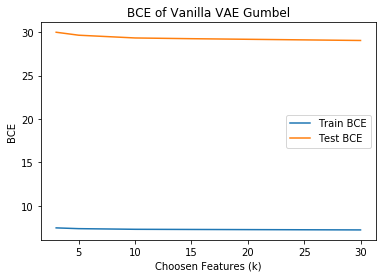

In [118]:
fig = plt.figure()
plt.plot(k_lab, train_bces, label = 'Train BCE')
plt.plot(k_lab, test_bces, label = 'Test BCE')

plt.title("BCE of Vanilla VAE Gumbel")
plt.xlabel("Choosen Features (k)")
plt.ylabel("BCE")
plt.legend()

Batching Gumbel

In [119]:
train_bces = []
test_bces = []
for k in k_lab:
    train_bce = 0
    test_bce = 0
    for trial in range(1, 1+trial_num):
        # test model
        path = '../data/models/final_run/batching_gumbel_vae/k_{}/model_trial_{}.pt'.format(k, trial_num)
        model = VAE_Gumbel_NInsta(2*D, 100, 20, k = k, t = global_t) 
        model.load_state_dict(torch.load(path))
        model.to(device)
        train_bce += bce_model(train_data, model)
        test_bce += bce_model(test_data, model)
    train_bces.append((train_bce/trial_num).item())
    test_bces.append((test_bce/trial_num).item())

print("Batching Gumbel VAE")
print("Train BCES")
print(train_bces)
print("Test BCES")
print(test_bces)

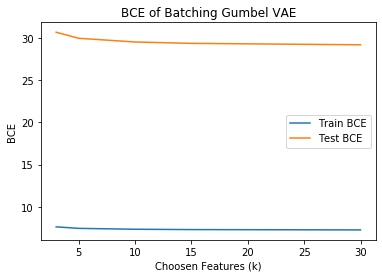

In [120]:
fig = plt.figure()
plt.plot(k_lab, train_bces, label = 'Train BCE')
plt.plot(k_lab, test_bces, label = 'Test BCE')

plt.title("BCE of Batching Gumbel VAE")
plt.xlabel("Choosen Features (k)")
plt.ylabel("BCE")
plt.legend()

Global Gate VAE

In [121]:
train_bces = []
test_bces = []
for k in k_lab:
    train_bce = 0
    test_bce = 0
    for trial in range(1, 1+trial_num):
        # test model
        path = '../data/models/final_run/globalgate_vae/k_{}/model_trial_{}.pt'.format(k, trial_num)
        model = VAE_Gumbel_GlobalGate(2*D, 100, 20, k = k, t = global_t) 
        model.load_state_dict(torch.load(path))
        model.to(device)
        train_bce += bce_model(train_data, model)
        test_bce += bce_model(test_data, model)
    train_bces.append((train_bce/trial_num).item())
    test_bces.append((test_bce/trial_num).item())

print("Global Gate VAE")
print("Train BCES")
print(train_bces)
print("Test BCES")
print(test_bces)

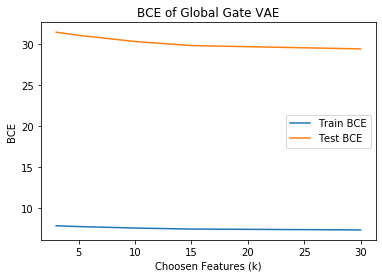

In [122]:
fig = plt.figure()
plt.plot(k_lab, train_bces, label = 'Train BCE')
plt.plot(k_lab, test_bces, label = 'Test BCE')

plt.title("BCE of Global Gate VAE")
plt.xlabel("Choosen Features (k)")
plt.ylabel("BCE")
plt.legend()

Concrete VAE

In [123]:
train_bces = []
test_bces = []
for k in k_lab:
    train_bce = 0
    test_bce = 0
    for trial in range(1, 1+trial_num):
        # test model
        path = '../data/models/final_run/concrete_vae_nmsl/k_{}/model_trial_{}.pt'.format(k, trial_num)
        model = ConcreteVAE_NMSL(2*D, 100, 20, k = k, t = global_t) 
        model.load_state_dict(torch.load(path))
        model.to(device)
        train_bce += bce_model(train_data, model)
        test_bce += bce_model(test_data, model)
    train_bces.append((train_bce/trial_num).item())
    test_bces.append((test_bce/trial_num).item())
    
print("Concrete VAE")
print("Train BCES")
print(train_bces)
print("Test BCES")
print(test_bces)

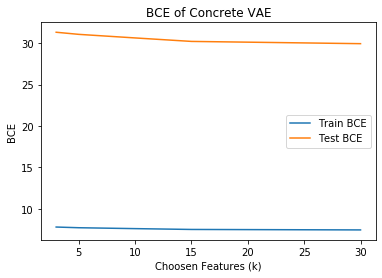

In [124]:
fig = plt.figure()
plt.plot(k_lab, train_bces, label = 'Train BCE')
plt.plot(k_lab, test_bces, label = 'Test BCE')

plt.title("BCE of Concrete VAE")
plt.xlabel("Choosen Features (k)")
plt.ylabel("BCE")
plt.legend()

Look at Top Logits and Top Subsets of Each Method

In [ ]:
def visualize_top_vanilla_vae_gumbel():
    
    inds = np.arange(data.shape[0])
    for k in k_lab:
        all_logits = torch.zeros(train_data.shape[1], dtype = torch.float32)
        all_subsets = torch.zeros(train_data.shape[1], dtype = torch.float32)
        all_logits = all_logits.to(device)
        all_subsets = all_subsets.to(device)
        for trial in range(1, 1+trial_num):
            # test model
            path = '../data/models/final_run/vanilla_vae_gumbel/k_{}/model_trial_{}.pt'.format(k, trial_num)
            model = VAE_Gumbel(2*D, 100, 20, k = k, t = global_t) 
            model.load_state_dict(torch.load(path))
            model.to(device)
            logits, gumbels = top_logits_gumbel_vanilla_vae_gumbel(test_data, model)
            
            all_logits += logits
            all_subsets += gumbels
            
        all_logits /= trial_num
        all_subsets /= trial_num
        
    